To do:
1. Determine if perturbative series should converge by looking at $\langle \psi_{1,0,0} | V' | \psi_{2,0,0} \rangle$ compared to $\frac{1}{2}|E_2 - E_1|$ using both perturbing approaches for different thicknesses (see [Eq. 1.1.47](https://ocw.mit.edu/courses/physics/8-06-quantum-physics-iii-spring-2018/lecture-notes/MIT8_06S18ch1.pdf)) from Barton Zwiebach's awesome notes.

#### Result: For 2 ML and the 5 ML case $|\langle |\psi_{1,0,0} | V' | \psi_{2,0,0} \rangle|$ >$\frac{1}{2}|E_2 - E_1|$, which suggests the perturbative series will *not* converge.



2. Implement 3rd order correction as long as it appears that the series should converge... Since the results from 1. suggest it will not converge, maybe building Hamiltonian matrix in basis of the 0th order states and diagonalizing (i.e. linear variational method) would be better.

In [10]:

import numpy as np
from matplotlib import pyplot as plt
from scipy.special import genlaguerre
from scipy.special import sph_harm
from scipy.interpolate import UnivariateSpline
from numpy import linalg as LA
from scipy.sparse.linalg import eigs
import math

''' Define various constants here! '''
###  !!!! npl thickness in nanometers, see page 2 of manuscript
#### 2 mL d_nm = 0.7
#### 5 mL = 1.9 nm
d_nm = 0.7

# conversion from nm to atomic units
nm_to_au = 18.89725988579

# d in atomic units
d = d_nm * nm_to_au

# electron-hole reduced mass in atomic units
mu = 0.22
# relative permittivity of NPL... see page 10 of the manuscript
eps_m = 10
# relative permittivity of medium.... see page 10 of the manuscript
eps_sol = 2
# k = 4*pi*epsilon_0 in atomic units
k = 1
# hbar in atomic units
hbar = 1
# electron charge in atomic units
ec = 1

''' It is now unclear to me if we can hard-code the bohr radius and
    still assume that psi_nlm(r,theta,phi; a0) is an eigenfunction of H_0
    so I'm reverting to computing a0 from \mu and \epsilon for now 
# bohr radius in atomic units using Azmain's value
#a0b = 0.82*18.89725988579 

# zeroth order ground state approach B - using Azmain's value of a0, which is a0b
#E_z = -ec**2/(8*np.pi*eps_m * a0b) '''

# a0 = 4*pi*epsilon_0 * epsilon_m * hbar^2 / (mu * e^2)
# in atomic units, everything is 1 except epsilon_m / mu 
a0b = eps_m / mu

# take the two different approaches for computing the ground-state energy
# (1) E_n = -mu * e^4/(n^2 * 2 * (4 pi epsilon_0)^2 epsilon_m^2 \hbar^2)
#     where in atomic units, everything is 1 except
#     E_n = -mu / (n^2 * 2 * epsilon_m^2 )
# 
# (2) E_n = -e^2 / (n^2 * 2 * (4 * pi * epsilon_0) * epsilon_m * a0)
#     where in atomic units, everything is 1 except
#     E_n = -1/(n^2 * 2 * epsilon_m * a0)

def En_using_mu(n, redmass, epsilon_m):
    return -redmass / (n**2 * 2 * epsilon_m**2)

def En_using_a(n, a0, epsilon_m):
    return -1/(n**2 * 2 * epsilon_m * a0)

# get Eg using approach (1)
E1_from_mu = En_using_mu(1, mu, eps_m)
# get Eg using approach (2)
E1_from_a0 = En_using_a(1, a0b, eps_m)

print(" bohr radius in atomic units:",a0b)
print(" bohr radius in nm:",a0b/nm_to_au)
print(" E1 from mu:", E1_from_mu * 27.211 * 1000)
print(" E1 from a0:", E1_from_a0 * 27.211 * 1000)
print(" Difference:",(E1_from_mu-E1_from_a0)*27.211*1000)
print(" Nanoplatlet thickness in nanometers", d_nm)
print(" Nanoplatlet thickness in atomic units", d)



 bohr radius in atomic units: 45.45454545454545
 bohr radius in nm: 2.405351131818084
 E1 from mu: -29.9321
 E1 from a0: -29.9321
 Difference: 0.0
 Nanoplatlet thickness in nanometers 0.7
 Nanoplatlet thickness in atomic units 13.228081920052999


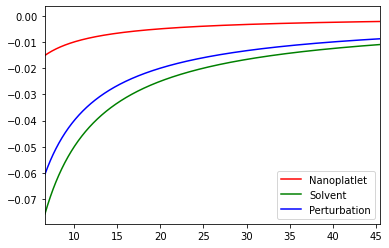

In [11]:

# To see if the perturbation is 'small', we need
# to know the gap between the 0th order eigenstates
# we will use the DeltaE_{1,2} gap
# as compared to the size of the <\psi_{100} | V' | \psi_{200}>
# element to determine if the perturbation is small.

# 1/2 * |E_2 - E_1| for when we consider
# the solvent to be the perturbation
### E_1 to zeroth order
E1_zo = En_using_mu(1, mu, eps_m)
### E_2 to zeroth order
E2_zo = En_using_mu(2, mu, eps_m)

gap_npl = 0.5 * np.abs(E2_zo - E1_zo)

''' Set up grids for the potential and the wavefunction '''
# radius grid in atomic units
r_perturb = np.linspace(d/2, 500, 50000)
r_array = np.linspace(1e-9, 5000, 50000)
# theta grid
th = np.linspace(0, np.pi, 100)
# phi grid
phi = np.linspace(0, 2*np.pi, 100)

# perturbing potential
V_perturb = ec**2 * (eps_sol - eps_m)/(k*eps_sol*eps_m*r_perturb)
# potential in nanoplatlet
Vnp = -ec**2/(k * eps_m * r_perturb)
# potential in solvent 
Vsol = -ec**2/(k*eps_sol * r_perturb)


plt.plot(r_perturb, Vnp, 'red', label="Nanoplatlet")
plt.plot(r_perturb, Vsol, "green", label="Solvent")
plt.plot(r_perturb, V_perturb, "blue", label="Perturbation")
plt.xlim(d/2, a0b)
plt.legend()
plt.show()

In [12]:
# To get perturbative corrections, we need to be able to generate
# 0th-order eigenfunctions and eigenenergies!  

# 0th order eigenfunction radial part
def R(n,l,r, a0):
    '''Returns the radial wavefunction for each value of r where n is the principle quantum number 
         and l is the angular momentum quantum number.'''
    norm = np.sqrt( (2/(n*a0))**3 * math.factorial(n - l - 1)/(math.factorial(n+l) * 2 * n))
    t1 = np.exp(-r/(n*a0))
    t2 = (2*r/(n*a0))**l
    #Generates an associated laguerre polynomial as a scipy.special.orthogonal.orthopoly1
    Lag = genlaguerre(n-l-1, 2*l+1)
    t3 = Lag(2*r/(n*a0))
    return norm * t1 * t2 * t3

def test_norm(n, l, r, theta, a0):
    # bra state
    R_bra = R(n, l, r, a0)
    Y_bra = sph_harm(0, l, 0, theta)
    
    R_integrand = np.conj(R_bra) * R_bra * r * r
    Y_integrand = np.real(np.conj(Y_bra) * Y_bra * np.sin(theta))
    
    R_integral = np.trapz(R_integrand, r)
    Y_integral = np.trapz(Y_integrand, theta)
    return 2*np.pi*R_integral*Y_integral





#  return <\psi_100 | V' | psi_nl0 >
def pt2_nl(n, l, Vp, r, theta, a0, npl_thickness):
    ''' We can factor the integral over phi from the integral over theta and r...
        plus integral over theta and r just becomes integral over r weighted by
        the slices of theta that extend outslide the platlet since we cannot couple
        m != 1 states to the psi_100 state through this potential, so the
        0th-order eigenfunctions are all constants along \theta!!!! '''
    
    ### get 0th-order ket terms
    R_bra = R(1, 0, r, a0)
    Y_bra = sph_harm(0, 0, 0, theta)
    
    ### get 0th-order bra terms
    R_ket = R(n, l, r, a0)
    Y_ket = sph_harm(0, l, 0, theta)
    
    #plt.plot(theta, np.conj(Y_bra)*Y_ket * np.sin(theta) , 'green')
    #plt.show()
    
    ### compute integrand over theta
    Y_integrand = np.real(np.conj(Y_bra) * Y_ket * np.sin(theta))
    ### fit spline to integrand over theta
    Y_spline = UnivariateSpline(theta, Y_integrand)
    fac_phi = 2*np.pi
    
    dE = 0
    dr = r[1]-r[0]
    for i in range(0,len(r)):
        th_max = np.arccos(d/(2*r[i]))
        fac_theta_up = Y_spline.integral(0, th_max)
        fac_theta_down = Y_spline.integral(np.pi-th_max, np.pi)
        fac_theta = fac_theta_up + fac_theta_down
        dE += R_bra[i] * R_ket[i] * r[i]**2 * Vp[i] * dr * fac_theta
        
    return fac_phi * dE





In [13]:
# Now to see if the perturbation is small,
# evaluate <\psi_{100} | V' | \psi_{200}> and compare to the gap
# between E_2 and E_1 to 0th order

V_12 = pt2_nl(2, 0, V_perturb, r_perturb, th, a0b, d )
print(np.abs(V_12)/gap_npl)

2.8331418791208836


In [ ]:
### Get 1st order energy correction
dE_1 = np.real(pt2_nl(1, 0, V_perturb, r_perturb, th, a0b, d))

### Get 2nd order energy correction
dE_2 = 0.

### arrays for zeroth and first order |R_10> states
R_zero_order = R(1, 0, r_array, a0b)
R_first_order = np.copy(R_zero_order)

tn = test_norm(1, 0, r_array, th, a0b)
print(" Testing normalization of R_10 * Y_00:", tn)
# E_1^{0} for denominator
print("")
print(" Going to print coefficients for each term in the 2nd order correctio")
E_1 = En_using_mu(1, mu, eps_m)
for n_val in range(2, 10):
  # E_n^{0} for denominator
  E_n = En_using_mu(n_val, mu,  eps_m)
  for l_val in range(0, n_val):
    # < psi_100 | V' | psi_nl0> for numerator
    num = pt2_nl(n_val, l_val, V_perturb, r_perturb, th, a0b, d )
    den = E_1 - E_n
    print("  c_",n_val,l_val,0,": ",num/den)
    dE_2 += np.abs(num**2)/den
    R_first_order += num/den * R(n_val, l_val, r_array, a0b)
    ### uncomment if you want to test normalization of states!
    ##tn = test_norm(n_val, l_val, r_array, th, a0b)
    ##print(" Test Norm ", n_val, l_val, tn)

print("")
print("")
print(" FINAL RESULTS FOR NPL thickness ",d_nm, "nm")
print(" Binding Energy:", -1*(E_1+dE_1+dE_2)*27.211*1000, "meV")
print("")
print(" Components:")
print(" E^{0}",-1*E_1*27.211*1000)
print(" E^{1}",-1*dE_1*27.211*1000)
print(" E^{2}",-1*dE_2*27.211*1000)

Norm_z0 = np.trapz(R_zero_order**2 * r_array**2, r_array)
Norm_f0 = np.trapz(R_first_order**2 * r_array**2, r_array)

r_num_z0 = np.trapz(R_zero_order**2 * r_array**3, r_array)
r_num_f0 = np.trapz(R_first_order**2 * r_array**3, r_array)

r_expt_z0 = r_num_z0 / Norm_z0

r_expt_f0 = r_num_f0 / Norm_f0

print(" Note <r> for R_10^{(0)} should be 3/2 * a0 or", a0b*3/2,"atomic units")
print(" <r> for 0th order:", r_expt_z0)
print(" <r> for 1st order:", r_expt_f0)


#R_zero_order *= (1/Norm_z0)
#R_first_order *= (1/Norm_f0)
plt.plot(r_array, R_zero_order**2*r_array**2, 'red')
plt.plot(r_array, R_first_order**2*r_array**2, 'blue')
plt.xlim(0, 500)
plt.show()

### Perturbative correction to dielectric screening of the coulomb potential

We assume that within the nanoplatlet and in the solvent, the exciton experiences a coulomb potential that is screened by the dielectric constant of the nanoplatlet and solvent, respectively.  In the coordinate system of the exciton that has thickness $d$ along the $z$ axis, the columb potential can be written as

$$ V_{npl}(r) = -\frac{e^2}{4\pi \epsilon_{npl}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| \leq \frac{d}{2} $$

while in the solvent, the potential has the same coulomb form but is screened by the dielectric of the solvent rather than the nanoplatlet:

$$ V_{sol}(r) = -\frac{e^2}{4\pi \epsilon_{sol}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| > \frac{d}{2}.$$

The ground state energy of the exciton to 2$^{nd}$ order in perturbation theory then is 

$$ E_g = E_1^{(0)} + E_1^{(1)} + E_1^{(2)}, $$
and the binding energy is 
$$ E_B = -E_g \equiv -E_1^{(0)} - E_1^{(0)} - E_1^{(2)}.$$

Here we assume 

$$ \hat{H}_0 = -\frac{\hbar^2}{2\mu} \nabla^2 + V_{npl}(r) $$
where $\mu = \frac{m_e \cdot m_h}{m_e + m_h}$ and is taken to be 0.22 $m_e$ in this work.    

$E_1^{(0)}$ is the ordinary 3D hydrogen ground state energy with $\epsilon_{npl}$ screening the coulomb potential and the electron mass replaced by $\mu$.  We compute $E_1^{(0)}$ as follows:


$$ E_1^{(0)}  =  -\frac{ e^2}{8\pi\epsilon_{npl} \epsilon_0 a_0 }. $$

The first-order energy correction can be written as

$$ E_1^{(1)} = \int_0^{\infty} r^2 dr \int_0^{\pi}{\rm sin}\left( \theta \right) d\theta   \int_0^{2\pi} d\phi  \: \psi^{(0)*}_{100} (r, \theta, \phi) V'(r,\theta) \psi^{(0)}_{100} (r, \theta, \phi),  $$

where 
\begin{align} 
V'(r,\theta) &= \left(V_{sol}(r) - V_{npl}(r)\right) H(|r \: {\rm cos}(\theta)|-\frac{d}{2}) \\
V'(r,\theta) &= \frac{e^2\left(\epsilon_{sol}-\epsilon_{npl} \right)}{4\pi \epsilon_{sol}\epsilon_{npl}\epsilon_0 r} H(|r \: {\rm cos}(\theta)|-\frac{d}{2}),
\end{align}
where $H(|r \: {\rm cos}(\theta)|-\frac{d}{2})$ is the Heaviside function that turns the perturbating potential on for regions of the excitonic coordinate the extend beyond the nanoplatlet.


The zeroth-order ground-state wavefunction is

$$ \psi^{(0)}_{1,0,0}(r,\theta, \phi) = \frac{1}{\sqrt{\pi}} \left( \frac{Z}{a_0}\right)^{3/2} e^{-Zr/a_0} \equiv R_{1,0}(r) Y_0^0(\theta, \phi), $$
where

$$a_0 = \frac{4 \pi \epsilon_{npl} \epsilon_0 \hbar^2}{\mu e^2} $$ 

and $Z = 1$.

$R_{1,0}$ is the Hydrogenic $1s$ radial function,
and $Y_{0,0}$ is the Spherical harmonic with $l=0, m=0$.
We can factor out the integral over $\phi$ 
and parameterize the range of integration 
over $\theta$ in terms of $r$:

$$ E_1^{(1)} =  2\pi  \int_{d/2}^{\infty} dr  \: r^2  R_{1,0}^2(r) V'(r) \left(\int_0^{f(r)} d\theta \:{\rm sin}(\theta) |Y_{0,0}(\theta, 0)|^2 +  \int_{\pi - f(r)}^{\pi} d\theta \:{\rm sin}(\theta) |Y_{0,0}(\theta, 0)|^2 \right),  $$

where $f(r) = {\rm cos}^{-1}\left(\frac{d}{2r} \right).$

The second-order energy correction can be written
\begin{align}
& E_1^{(2)} = \sum_{n,l} \frac{2\pi}{E_1^{(0)}-E_n^{(0)}} \times \\
&\int_{d/2}^{\infty} dr  \: r^2  R_{1,0} V'(r) R_{n,l} \left(\int_0^{f(r)} d\theta \:{\rm sin}(\theta) Y^*_{0,0}(\theta, 0)Y_{l,0}(\theta, 0) +  \int_{\pi - f(r)}^{\pi} d\theta \:{\rm sin}(\theta) Y^*_{0,0}(\theta, 0)Y_{l,0}(\theta, 0) \right).
\end{align}


In [ ]:
''' Define various constants here! '''
# electron-hole reduced mass in atomic units
mu = 0.22
# relative permittivity of NPL... see page 10 of the manuscript
eps_m = 10
# relative permittivity of medium.... see page 10 of the manuscript
eps_sol = 2
# k = 4*pi*epsilon_0 in atomic units
k = 1
# hbar in atomic units
hbar = 1
# electron charge in atomic units
ec = 1
# bohr radius in atomic units in approach a
a0a = k*hbar**2*eps_m/(mu*ec**2)

# bohr radius in atomic units in approach b
a0b = 0.82*18.89725988579 


# zeroth order ground state approach A
E_z_1A = -mu*ec**4/(2 * (k * eps_m)**2 * hbar**2)

# zeroth order ground state approach B - using Azmain's value of a0, which is a0b
# !!! JJF Note... 4\pi \epsilon_0 is 1 in atomic units, so this 
# expression should just be -1/(2*eps_m * a0b)
E_z_1B = -ec**2/(2*eps_m * a0b)

# npl thickness in nanometers, see page 2 of manuscript
#### 2 mL d_nm = 0.7
#### 5 mL = 1.9 nm
d_nm = 0.7

# conversion from nm to atomic units
nm_to_au = 18.89725988579

# d in atomic units
d = d_nm * nm_to_au

''' print out some information here! '''
print("  a_{0,a} in atomic units", a0a)
print("  a_{0,a} in nm", a0a/nm_to_au)

print("  a_{0,b} in atomic units", a0b)
print("  a_{0,b} in nm", a0b/nm_to_au)

print("  Nanoplatlet thickness in nanometers", d_nm)
print("  Nanoplatlet thickness in atomic units", d)

print("  E_{1,A}^{(0)} in atomic units", E_z_1A)
print("  E_{1,A}^{(0)} in meV", E_z_1A*27.211*1000)

print("  E_{1,B}^{(0)} in atomic units", E_z_1B)
print("  E_{1,B}^{(0)} in meV", E_z_1B*27.211*1000)


In [ ]:
''' Set up grids for the potential and the wavefunction '''
# radius grid in atomic units
r = np.linspace(1e-9, 250, 500)
# theta grid
th = np.linspace(0, np.pi, 500)

# theta part of psi_100
TH = np.sin(th)

# psi_100
psi_100_a = (1/np.sqrt(np.pi))*(1/a0a)**(3/2) * np.exp(-r/a0a)
psi_100_b = (1/np.sqrt(np.pi))*(1/a0b)**(3/2) * np.exp(-r/a0b)



Vp = -ec**2 * (eps_sol - eps_m)/(k*eps_sol*eps_m*r)

# print both spline and trapezoid rule
plt.plot(r, psi_100_a*psi_100_a*r*r, 'red', label='a_{0,a}')
plt.plot(r, psi_100_b*psi_100_b*r*r, 'b--', label='a_{a,b}')
plt.legend()
plt.show()



In [ ]:
dtheta = th[1]-th[0]

dr = r[1]-r[0]


### factor out integral over phi
dE_1_a = 0
dE_1_b = 0
for i in range(0,len(r)):
  for j in range(0,len(th)):
    if abs(r[i] * np.cos(th[j])) > d/2:
      dE_1_a += psi_100_a[i]**2 * r[i]**2 * Vp[i] * dr * TH[j] * dtheta * 2*np.pi
      dE_1_b += psi_100_b[i]**2 * r[i]**2 * Vp[i] * dr * TH[j] * dtheta * 2*np.pi

print(" E^{(0)}_{1,A}:", E_z_1A*27.211*1000, "meV")
print(" E^{(0)}_{1,B}:", E_z_1B*27.211*1000, "meV")

print(" E^{(1)}_{1,A}:", dE_1_a * 27.211 * 1000, "meV")
print(" E^{(1)}_{1,B}:", dE_1_b * 27.211 * 1000, "meV")

print(" E_{1,Aa}:", (E_z_1A+dE_1_a)*27.211*1000, "meV" )
print(" E_{1,Ab}:", (E_z_1A+dE_1_b)*27.211*1000, "meV" )
print(" E_{1,Ba}:", (E_z_1B+dE_1_a)*27.211*1000, "meV" )
print(" E_{1,Bb}:", (E_z_1B+dE_1_b)*27.211*1000, "meV" )

In [ ]:
plt.plot(r, Vp, 'r-o', label="V")
plt.ylim(0,1)
plt.legend()
plt.show()